## Importando librerias

In [41]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

## Cargando datos de peliculas después de la extracción (Scrapping)

In [42]:
movie_data = pd.read_csv('movieDescriptionDataSet.tsv', sep="\t", encoding ='iso-8859-1')

## Describiendo los datos textuales de Películas

In [43]:
# Número de registros
movie_data.shape

(5973, 6)

In [44]:
def describe_dataframe(df=pd.DataFrame()):
    """This function generates descriptive stats of a dataframe
    Args:
        df (dataframe): the dataframe to be analyzed
    Returns:
        None

    """
    print("\n\n")
    print("*"*30)
    print("About the Data")
    print("*"*30)
    
    print("Number of rows::",df.shape[0])
    print("Number of columns::",df.shape[1])
    print("\n")
    
    print("Column Names::",df.columns.values.tolist())
    print("\n")
    
    print("Column Data Types::\n",df.dtypes)
    print("\n")
    
    print("Columns with Missing Values::",df.columns[df.isnull().any()].tolist())
    print("\n")
    
    print("Number of rows with Missing Values::",len(pd.isnull(df).any(1).nonzero()[0].tolist()))
    print("\n")
    
    print("Sample Indices with missing data::",pd.isnull(df).any(1).nonzero()[0].tolist()[0:5])
    print("\n")
    
    print("General Stats::")
    print(df.info())
    print("\n")
    
    print("Summary Stats::")
    print(df.describe())
    print("\n")
    
    print("Dataframe Sample Rows::")
    display(df.head(5))

In [45]:
describe_dataframe(movie_data)




******************************
About the Data
******************************
Number of rows:: 5973
Number of columns:: 6


Column Names:: ['Title', 'Description', 'Genre', 'Rating', 'Link', 'Date']


Column Data Types::
 Title           object
Description     object
Genre           object
Rating         float64
Link            object
Date            object
dtype: object


Columns with Missing Values:: []


Number of rows with Missing Values:: 0


Sample Indices with missing data:: []


General Stats::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5973 entries, 0 to 5972
Data columns (total 6 columns):
Title          5973 non-null object
Description    5973 non-null object
Genre          5973 non-null object
Rating         5973 non-null float64
Link           5973 non-null object
Date           5973 non-null object
dtypes: float64(1), object(5)
memory usage: 280.1+ KB
None


Summary Stats::
            Rating
count  5973.000000
mean     63.640717
std      12.392329
min       0.00

,Title,Description,Genre,Rating,Link,Date
0,Aquaman,The film reveals the origin story of half-huma...,"ACTION,FANTASY,SCIENCE FICTION,ADVENTURE,ROMANCE",65.0,/movie/297802,"December 21, 2018"
1,Venom,Eddie Brock is a reporterinvestigating people...,SCIENCE FICTION,65.0,/movie/335983,"October 5, 2018"
2,Fantastic Beasts: The Crimes of Grindelwald,Gellert Grindelwald has escaped imprisonment a...,"FAMILY,FANTASY,ADVENTURE",70.0,/movie/338952,"November 16, 2018"
3,Mortal Engines,Set in a world many thousands of years in the ...,SCIENCE FICTION,61.0,/movie/428078,"December 14, 2018"
4,Mowgli: Legend of the Jungle,"A human child raised by wolves, must face off ...","ADVENTURE,DRAMA",68.0,/movie/407436,"November 29, 2018"


In [46]:
movie_data.groupby('Genre')['Title'].count()

Genre
ACTION                                                               23
ACTION,ADVENTURE                                                     16
ACTION,ADVENTURE,ANIMATION                                            3
ACTION,ADVENTURE,ANIMATION,COMEDY,FAMILY                              3
ACTION,ADVENTURE,ANIMATION,COMEDY,FAMILY,FANTASY                      1
ACTION,ADVENTURE,ANIMATION,COMEDY,FAMILY,FANTASY,SCIENCE FICTION      1
ACTION,ADVENTURE,ANIMATION,CRIME,FAMILY,MYSTERY                       1
ACTION,ADVENTURE,ANIMATION,DRAMA                                      1
ACTION,ADVENTURE,ANIMATION,FAMILY                                     3
ACTION,ADVENTURE,ANIMATION,FAMILY,FANTASY,COMEDY                      1
ACTION,ADVENTURE,ANIMATION,FAMILY,SCIENCE FICTION                     1
ACTION,ADVENTURE,ANIMATION,FANTASY                                    2
ACTION,ADVENTURE,ANIMATION,FANTASY,HORROR,MYSTERY,SCIENCE FICTION     1
ACTION,ADVENTURE,ANIMATION,SCIENCE FICTION                

# Cleaning Text - strip HTML

In [47]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [14]:
# Removing accented characters

In [48]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [ ]:
# Expanding Contractions

In [49]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [15]:
# Removing Special Characters

In [50]:
def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

In [17]:
# Lemmatizing text

In [51]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [19]:
# Removing Stopwords

In [52]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [21]:
# Normalize text corpus - tying it all together

In [53]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [23]:
# Normalizacion

In [54]:
movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Description'].tolist()

print ("Movie:", movie_titles[0])
print ("Movie Description:", movie_synopses[0][:1000])

Movie: Aquaman
Movie Description: The film reveals the origin story of half-human, half-Atlantean Arthur Curry and takes him on the journey of his lifetimeone that will not only force him to face who he really is, but to discover if he is worthy of who he was born to be a king.


In [55]:
norm_movie_synopses = normalize_corpus(movie_synopses, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=False, 
                     stopword_removal=True)
norm_movie_synopses

['film reveal origin story half - human , half - atlantean arthur curry take journey lifetimeone not force face really , discover worthy bear king .',
 'eddie brock reporterinvestigat people want go unnoticed . make terrible discovery life foundation , begin transform venom . foundation discover creature call symbiote , believe key next step human evolution . unwittingly bond one , eddie discover incredible new abilitiesand voice head tell embrace darkness .',
 'gellert grindelwald escape imprisonment begin gather follower causeelevating wizard non - magical . one capable put stop wizard call close friend , albus dumbledore . however , dumbledore need seek help wizard thwart grindelwald , former student newt scamander , agree help , unaware danger lie ahead . line draw love loyalty test , even among true friend family , increasingly divided wizard world .',
 'set world many thousand year future . earth city roam globe huge wheel , devour struggle ever diminish resource . one massive tr

In [ ]:
# Bag of Words Model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_movie_synopses)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [19]:
vocab = cv.get_feature_names()
pd.DataFrame(cv_matrix, columns=vocab)

,00,000,007,10,100,1000,1001,100th,101,108,...,zorro,zs,zucchini,zuckerberg,zugor,zula,zulu,zulus,zune,zuru
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# TF-IDF Model

In [60]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# extract tf-idf features
vectorizer = TfidfVectorizer(max_features=1000)
# vectorizer = TfidfVectorizer()
feature_matrix = vectorizer.fit_transform(norm_movie_synopses).astype(float)
# view number of features
print(feature_matrix.shape)

(5973, 1000)


In [61]:
# get feature names
feature_names = vectorizer.get_feature_names()

In [62]:
# print sample features
print (feature_names[:20])

['000', '10', '12', '20', 'abandon', 'ability', 'able', 'accept', 'accident', 'accidentally', 'accompany', 'accuse', 'across', 'act', 'action', 'actor', 'actress', 'actually', 'add', 'adopt']


In [28]:
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

num_clusters = 454    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters
# deteminar la cantidad de cluster adecuado
# Analizar las diferencias entre genero y los cluster
# Utilizar mas vectorizadores y otros cluster
# comparación de cluster
# Exploración de vocabularios, estadistica a nivel de palabras

In [37]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

dict_items([(241, 13), (250, 11), (18, 8), (273, 12), (139, 13), (197, 10), (165, 11), (443, 11), (226, 24), (289, 12), (8, 6), (383, 16), (392, 14), (141, 6), (38, 7), (328, 14), (0, 9), (433, 10), (244, 15), (332, 28), (320, 10), (431, 15), (399, 11), (333, 10), (305, 18), (87, 30), (319, 16), (253, 15), (103, 20), (128, 13), (82, 19), (249, 13), (323, 14), (140, 23), (346, 8), (288, 17), (29, 15), (377, 33), (231, 13), (58, 21), (216, 37), (269, 13), (318, 28), (327, 27), (213, 13), (175, 35), (291, 7), (89, 12), (352, 6), (84, 21), (237, 10), (286, 17), (387, 15), (180, 13), (279, 42), (222, 9), (277, 18), (424, 10), (335, 12), (57, 9), (358, 11), (367, 9), (302, 14), (36, 16), (72, 3), (106, 13), (425, 23), (64, 11), (215, 19), (322, 9), (115, 20), (427, 4), (154, 13), (240, 10), (445, 15), (147, 34), (52, 17), (364, 20), (63, 7), (390, 13), (282, 9), (98, 13), (153, 13), (312, 24), (254, 10), (311, 7), (290, 14), (176, 18), (157, 24), (439, 17), (256, 15), (422, 10), (104, 11), (

In [23]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=5):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details

In [32]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ("Cluster {} details:".format(cluster_num))
        print ("-"*20)
        print ("Key features:", cluster_details['key_features'])
        print ("Movies in this cluster:")
        print (", ".join(cluster_details['movies']))
        print ("="*40)

In [33]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'description': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['Title'], size=8)  
    # show the plot           
    plt.show() 

In [25]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

NameError: name 'km_obj' is not defined

C:\Users\user\Anaconda3.5.3.1\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\user\Anaconda3.5.3.1\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\user\Anaconda3.5.3.1\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\user\Anaconda3.5.3.1\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. 

KeyError: 'Title'

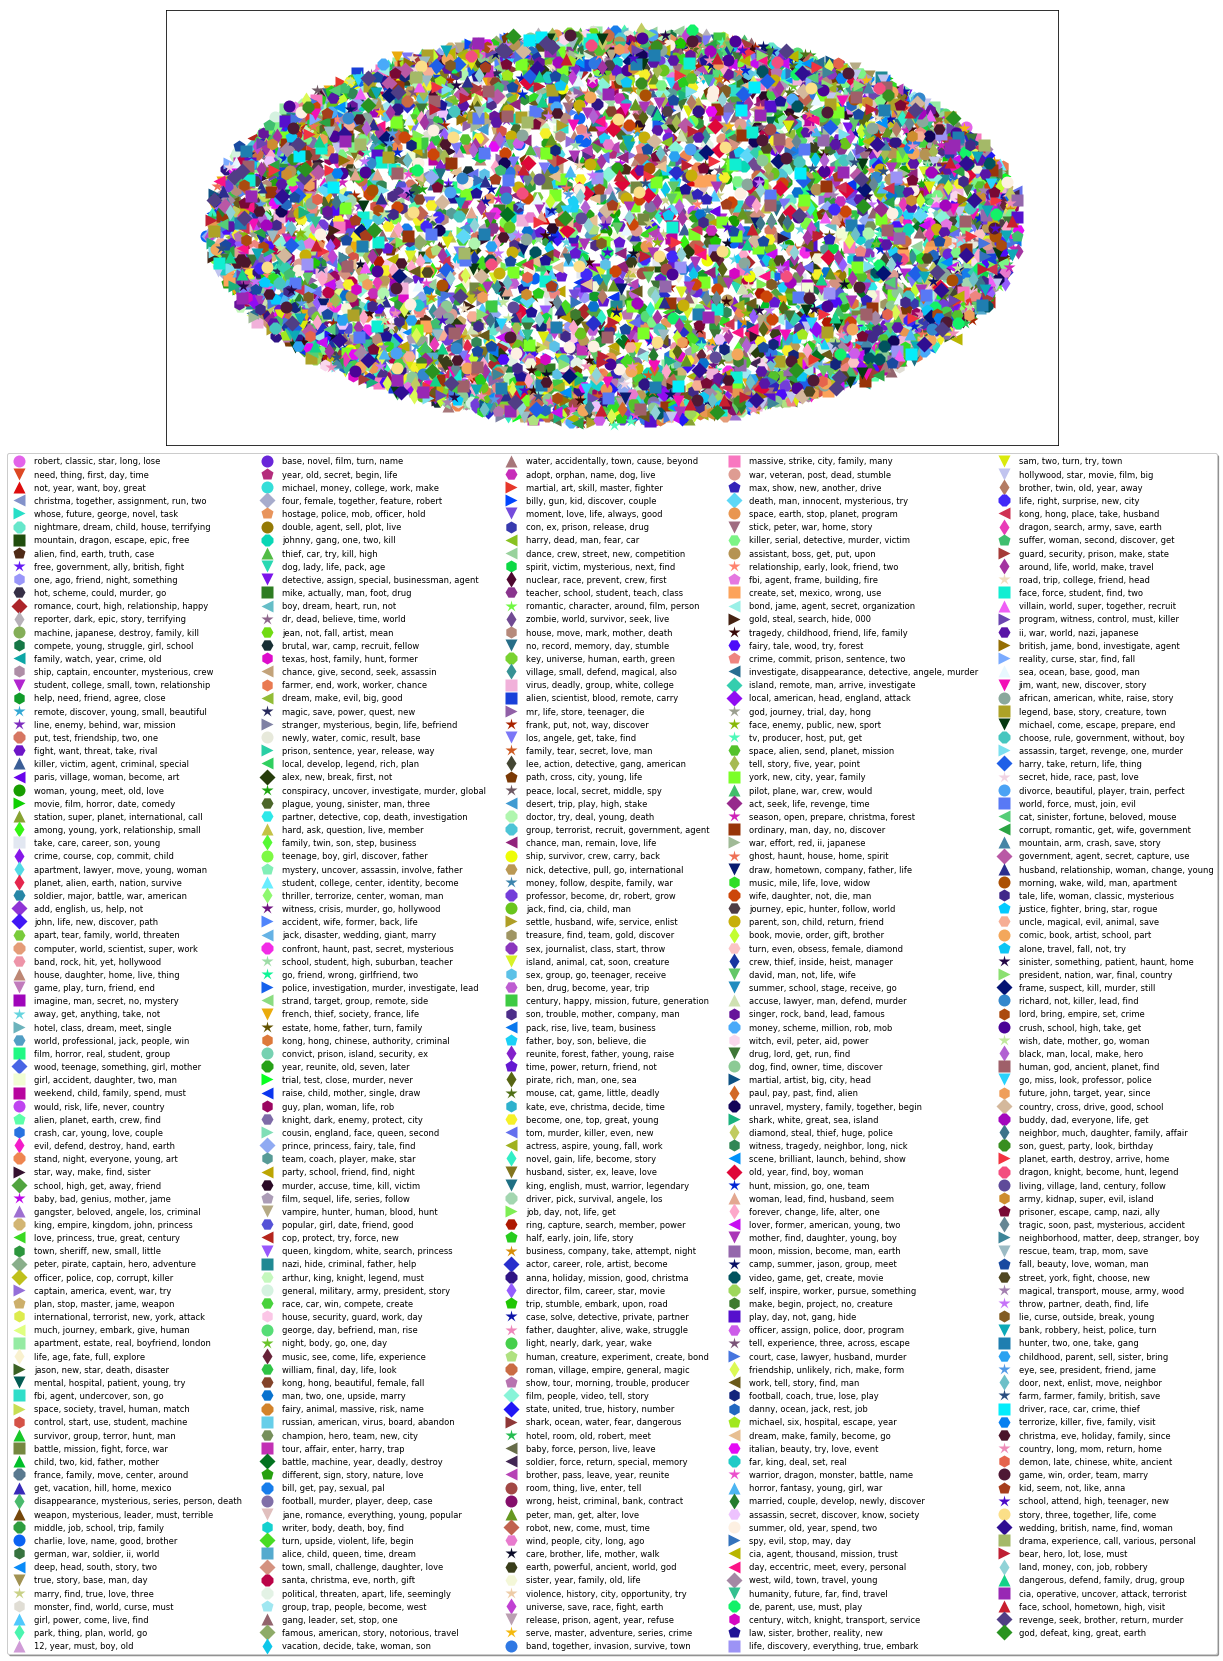

In [46]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))     

In [29]:
from sklearn.cluster import AffinityPropagation
              
def affinity_propagation(feature_matrix):
    
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters

In [30]:
# get clusters using affinity propagation
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

In [31]:
# get the total number of movies per cluster
c = Counter(clusters)   
print (c.items())

dict_items([(36, 11), (6, 13), (127, 18), (360, 14), (128, 6), (422, 19), (449, 19), (324, 17), (228, 20), (306, 35), (44, 15), (156, 12), (429, 7), (293, 18), (419, 15), (31, 12), (7, 32), (28, 28), (218, 11), (181, 8), (68, 9), (0, 8), (66, 8), (162, 29), (1, 17), (53, 26), (385, 19), (169, 7), (227, 8), (223, 14), (296, 9), (417, 12), (60, 12), (153, 11), (259, 15), (82, 34), (164, 13), (331, 17), (414, 47), (241, 16), (357, 20), (108, 8), (231, 21), (193, 21), (130, 14), (245, 10), (403, 16), (396, 9), (322, 20), (18, 18), (256, 21), (55, 10), (310, 13), (288, 24), (314, 13), (282, 19), (359, 9), (47, 6), (14, 20), (438, 15), (233, 10), (2, 11), (198, 7), (78, 19), (323, 13), (95, 7), (99, 15), (393, 15), (399, 10), (388, 9), (269, 12), (187, 28), (434, 14), (365, 4), (103, 24), (355, 18), (243, 13), (412, 19), (168, 10), (51, 17), (326, 16), (421, 12), (73, 11), (94, 20), (317, 8), (154, 20), (161, 13), (134, 23), (286, 9), (123, 34), (267, 34), (3, 16), (190, 31), (92, 11), (404,

In [32]:
# get total clusters
total_clusters = len(c)
print ("Total Clusters:", total_clusters)

Total Clusters: 454


In [33]:
n_features = 5
# get clustering analysis data
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=n_features
                                ) 

print_cluster_data(cluster_data)

IndexError: list index out of range

In [ ]:
num_clusters=454
plot_clusters(num_clusters=total_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 

In [47]:
from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix
    
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

C:\Users\user\Anaconda3.5.3.1\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


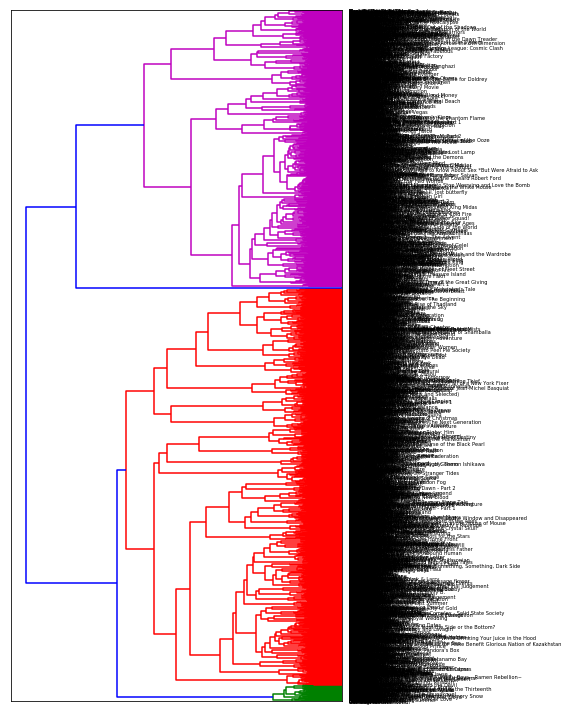

In [48]:
# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(8,10))

In [49]:
query_docs = ['The fox is definitely smarter than the dog',
            'Java is a static typed programming language unlike Python',
            'I love to relax under the beautiful blue sky!']

In [52]:
# normalize and extract features from the query corpus
norm_query_docs = normalize_corpus(query_docs, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=False, 
                     stopword_removal=True)
query_docs_tfidf = vectorizer.transform(norm_query_docs)

In [53]:
def compute_cosine_similarity(doc_features, corpus_features,
                              top_n=3):
    # get document vectors
    doc_features = doc_features.toarray()[0]
    corpus_features = corpus_features.toarray()
    # compute similarities
    similarity = np.dot(doc_features, 
                        corpus_features.T)
    # get docs with highest similarity scores
    top_docs = similarity.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(similarity[index], 3))
                            for index in top_docs]
    return top_docs_with_score

In [54]:
print ("Document Similarity Analysis using Cosine Similarity")
print ("="*60)
for index, doc in enumerate(query_docs):
    
    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_cosine_similarity(doc_tfidf,
                                             feature_matrix,
                                             top_n=2)
    print ("Document",index+1 ,":", doc)
    print ("Top", len(top_similar_docs), "similar docs:")
    print ("-"*40 )
    for doc_index, sim_score in top_similar_docs:
        print ("Doc num: {} Similarity Score: {}\nDoc: {}".format(doc_index+1,
                                                                 sim_score,
                                                                 norm_movie_synopses[doc_index]))  
        print ("-"*40)       
    print    

Document Similarity Analysis using Cosine Similarity
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 5162 Similarity Score: 0.706
Doc: talent scout spot perform dog boi charity gala , sharpay evan set bright light nyc , convinced instant fame fortune bag . theatre dog - eat - dog world . fortunately , sharpay also meet peyton , handsome student filmmaker find sharpay nearly fascinating find .
----------------------------------------
Doc num: 1202 Similarity Score: 0.677
Doc: max , macho , solitary rottweiler police dog order go undercover primped show dog prestigious dog show , along human partner , avert disaster happen .
----------------------------------------
Document 2 : Java is a static typed programming language unlike Python
Top 2 similar docs:
----------------------------------------
Doc num: 5973 Similarity Score: 0.0
Doc: spirited girl find catch complicated love triangle burden societal familial p

In [55]:
def compute_hellinger_bhattacharya_distance(doc_features, corpus_features,
                                            top_n=3):
    # get document vectors                                            
    doc_features = doc_features.toarray()[0]
    corpus_features = corpus_features.toarray()
    # compute hb distances
    distance = np.hstack(
                    np.sqrt(0.5 *
                            np.sum(
                                np.square(np.sqrt(doc_features) - 
                                          np.sqrt(corpus_features)), 
                                axis=1)))
    # get docs with lowest distance scores                            
    top_docs = distance.argsort()[:top_n]
    top_docs_with_score = [(index, round(distance[index], 3))
                            for index in top_docs]
    return top_docs_with_score 

print ("Document Similarity Analysis using Hellinger-Bhattacharya distance")
print ("="*60)
for index, doc in enumerate(query_docs):
    
    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_hellinger_bhattacharya_distance(doc_tfidf,
                                             feature_matrix,
                                             top_n=2)
    print ("Document",index+1 ,":", doc)
    print ("Top", len(top_similar_docs), "similar docs:")
    print ("-"*40) 
    for doc_index, sim_score in top_similar_docs:
        print ("Doc num: {} Distance Score: {}\nDoc: {}".format(doc_index+1,
                                                                 sim_score,
                                                                 norm_movie_synopses[doc_index]))  
        print ("-"*40)
    print

Document Similarity Analysis using Hellinger-Bhattacharya distance
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 121 Distance Score: 1.0
Doc: katniss everdeen reluctantly become symbol mass rebellion autocratic capitol .
----------------------------------------
Doc num: 4059 Distance Score: 1.0
Doc: french marquis wander vast labyrinth corridor , theater ballroom reception persian ambassador .
----------------------------------------
Document 2 : Java is a static typed programming language unlike Python
Top 2 similar docs:
----------------------------------------
Doc num: 4059 Distance Score: 0.707
Doc: french marquis wander vast labyrinth corridor , theater ballroom reception persian ambassador .
----------------------------------------
Doc num: 5149 Distance Score: 0.707
Doc: fausto brizzis movie
----------------------------------------
Document 3 : I love to relax under the beautiful blue sky!
Top 2 simi

In [56]:
import scipy.sparse as sp 

def compute_corpus_term_idfs(corpus_features, norm_corpus):
    
    dfs = np.diff(sp.csc_matrix(corpus_features, copy=True).indptr)
    dfs = 1 + dfs # to smoothen idf later
    total_docs = 1 + len(norm_corpus)
    idfs = 1.0 + np.log(float(total_docs) / dfs)
    return idfs


def compute_bm25_similarity(doc_features, corpus_features,
                            corpus_doc_lengths, avg_doc_length,
                            term_idfs, k1=1.5, b=0.75, top_n=3):
    # get corpus bag of words features
    corpus_features = corpus_features.toarray()
    # convert query document features to binary features
    # this is to keep a note of which terms exist per document
    doc_features = doc_features.toarray()[0]
    doc_features[doc_features >= 1] = 1
    
    # compute the document idf scores for present terms
    doc_idfs = doc_features * term_idfs
    # compute numerator expression in BM25 equation
    numerator_coeff = corpus_features * (k1 + 1)
    numerator = np.multiply(doc_idfs, numerator_coeff)
    # compute denominator expression in BM25 equation
    denominator_coeff =  k1 * (1 - b + 
                                (b * (corpus_doc_lengths / 
                                        avg_doc_length)))
    denominator_coeff = np.vstack(denominator_coeff)
    denominator = corpus_features + denominator_coeff
    # compute the BM25 score combining the above equations
    bm25_scores = np.sum(np.divide(numerator,
                                   denominator),
                         axis=1)
    # get top n relevant docs with highest BM25 score                     
    top_docs = bm25_scores.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(bm25_scores[index], 3))
                            for index in top_docs]
    return top_docs_with_score

In [26]:
from sklearn.decomposition import PCA
pca_num_components = 100
tsne_num_components = 2
X = feature_matrix.todense()
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

In [63]:

num_clusters = 100    
km_obj, clusters = k_means(feature_matrix=reduced_data,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters

In [64]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

dict_items([(72, 55), (78, 68), (25, 46), (56, 60), (46, 67), (89, 88), (66, 15), (44, 54), (77, 97), (37, 66), (20, 40), (0, 90), (64, 355), (10, 92), (48, 99), (52, 72), (40, 91), (18, 58), (36, 43), (60, 86), (87, 30), (22, 58), (55, 94), (71, 68), (11, 85), (42, 85), (39, 66), (34, 104), (90, 49), (81, 54), (28, 62), (6, 69), (26, 57), (99, 48), (47, 47), (88, 103), (43, 40), (61, 53), (17, 29), (76, 101), (51, 66), (59, 88), (23, 65), (32, 51), (57, 83), (65, 84), (80, 45), (1, 62), (75, 94), (95, 87), (92, 76), (31, 66), (70, 85), (73, 42), (21, 58), (49, 72), (94, 43), (2, 51), (41, 36), (50, 37), (7, 96), (9, 88), (3, 62), (33, 42), (67, 72), (68, 85), (12, 32), (35, 58), (8, 21), (30, 21), (15, 22), (24, 51), (13, 22), (74, 75), (79, 93), (45, 58), (38, 65), (29, 59), (62, 60), (4, 76), (53, 26), (5, 18), (93, 54), (83, 56), (85, 54), (19, 39), (54, 67), (84, 67), (58, 74), (27, 54), (82, 7), (69, 4), (14, 22), (96, 19), (86, 4), (97, 6), (16, 6), (91, 1), (98, 1), (63, 1)])


In [65]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['across', 'already', 'accidentally', 'act', 'abandon']
Movies in this cluster:
Robin Hood, The Ballad of Buster Scruggs, All the Devil's Men, Gone with the Wind, The Matrix Revolutions, Suite Française, Apocalypse Now, The Time Machine, Starship Troopers, A Good Day to Die Hard, Indiana Jones and the Kingdom of the Crystal Skull, Star Wars: Episode II - Attack of the Clones, Justice League: Throne of Atlantis, The Patriot, Full Metal Jacket, 300: Rise of an Empire, Batman, Dances with Wolves, Allied, Rambo, Kingdom of Heaven, Star Wars: Episode III - Revenge of the Sith, Lawrence of Arabia, The Yellow Birds, Lincoln, The Rock, I, Frankenstein, We Were Soldiers, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Operation Chromite, The Ottoman Lieutenant, Star Wars: Episode IX, War Horse, John Carter, The Hurt Locker, Chinatown, Star Wars: The Clone Wars, The Reader, The Bridge on the River Kwai, Tinker Tailor Sol

Overlord, Shutter Island, Wonder Woman, The Imitation Game, Dunkirk, Air Strike, Fury, Schindler's List, Inglourious Basterds, Captain America: The First Avenger, The Day the Earth Stood Still, Darkest Hour, The Thin Red Line, Das Boot, Hellboy, Life Is Beautiful, The Outsider, Don't Look Now: We're Being Shot At, The League of Extraordinary Gentlemen, The English Patient, Unbroken, Their Finest, The Great Escape, Valkyrie, All Quiet on the Western Front, The Exception, Iron Sky, The Wind Rises, Lifeboat, Windtalkers, Bedknobs and Broomsticks, Where Eagles Dare, Black Book, Seven Years in Tibet, The Great Raid, Welcome to Marwen, Return to Never Land, Memoirs of a Geisha, Enigma, Appleseed, The Counterfeiters, Kelly's Heroes, M*A*S*H, Joyeux Noël, Dad's Army, Miracle at St. Anna, A Man Escaped, Catch-22, When the Wind Blows, Stealth, Lust, Caution, Hiroshima Mon Amour, The Dirty Dozen, Testament of Youth, East of Eden, U-571, Little Lips, The Master, The Rules of the Game, Charade, Bel

A Dog's Purpose, Avengers: Age of Ultron, Get Out, Life of the Party, Predator, Geostorm, Spy, Teen Titans Go! To the Movies, Horrible Bosses 2, American Pie 2, 10 Things I Hate About You, Fargo, National Lampoon's Vacation, The After Party, Prisoners, Star Trek, The Hangover Part III, Vacation, Knight and Day, Show Dogs, There's Something About Mary, Drive, Eight Crazy Nights, The Mummy, Addams Family Values, Meet the Parents, The Hangover Part II, Saw V, The Untouchables, American Pie Presents: Band Camp, The Leisure Seeker, Under the Sand, Just Visiting, Sympathy for Mr. Vengeance, What Dreams May Come, Dennis the Menace, Erin Brockovich, Diary of a Wimpy Kid: Dog Days, Four Christmases, Ideal Home, Rio 2, Eden Lake, The Burning, Fullmetal Alchemist, Half Baked, Layer Cake, Diary of a Wimpy Kid: The Long Haul, Heist, Big Daddy, Alligator, The Cat in the Hat, Reclaim, Free Fire, Before the Devil Knows You're Dead, Friday the 13th Part VI: Jason Lives, Angel Heart, The Jungle Book 2, 

Key features: ['accompany', 'allow', 'army', 'angele', 'ally']
Movies in this cluster:
Harry Potter and the Chamber of Secrets, Annihilation, The Fate of the Furious, Kamen Rider Amazons The Movie: The Final Judgement, Kong: Skull Island, Allegiant, Extinction, Detective Dee: The Four Heavenly Kings, Beauty and the Beast, Sherlock Gnomes, The Prestige, A Cure for Wellness, 20,000 Leagues Under the Sea, Once Upon a Time in the West, Errementari: The Blacksmith and the Devil, Eagle Eye, Angels & Demons, Scary Movie 3, The Shack, Dressed to Kill, The Sense of an Ending, Brotherhood of the Wolf, Insidious: Chapter 2, The Hidden Face, Cowboys & Aliens, Echelon Conspiracy, The Skin I Live In, The Villainess, The Wailing, Darker Shades of Elise, Vanishing on 7th Street, Odd Thomas, Black Mirror: White Christmas, Phantasm, Journal 64, Transsiberian, Tumbbad, Doctor Strange, Speed Racer, The Grudge 3, The Witches of Eastwick, Buster's Mal Heart, In the Mouth of Madness, The Medallion, Frank, Pa

I Give It a Year, Trading Places, The Huntsman: Winter's War, Set It Up, Sahara, 10 Cloverfield Lane, The Favourite, Passengers, Brokeback Mountain, Dumb and Dumber, Shark Tale, The Wages of Fear, Two Night Stand, 47 Meters Down, Wild Wild West, Big Trouble, Strangers on a Train, I Still Know What You Did Last Summer, The Land Before Time II: The Great Valley Adventure, Neon Genesis Evangelion: The End of Evangelion, Brooklyn, Four Lovers, What Doesn't Kill You, The Fly, The Way We Were, Vampires Suck, Vicky Cristina Barcelona, A Simple Plan, Silence, Swimming Pool, Before Midnight, Crystal Inferno, Pandorum, Love Is All You Need, Extinction, Euphoria, Open Season, 12 Feet Deep, Return to the Blue Lagoon, Weekend at Bernie's, The Way of the Gun, We're No Angels, National Security, Benji, Kama Sutra - A Tale of Love, Cassandra's Dream, Rosencrantz & Guildenstern Are Dead, The Second Best Exotic Marigold Hotel, Chestnut: Hero of Central Park, Much Ado About Nothing, Rushmore, The Adventu

Guardians of the Galaxy, The House with a Clock in Its Walls, The Darkest Minds, Harry Potter and the Half-Blood Prince, Uncle Drew, Call Me by Your Name, Hotel Transylvania 2, Lion, The Princess Diaries, Midnight Sun, Pan's Labyrinth, The Florida Project, Summer '03, The Notebook, All the Money in the World, Once Upon a Time in America, Man on Fire, The Child in Time, The Man from Earth: Holocene, The Little Witch, The Ages of Lulu, T2 Trainspotting, The Warning, The Age of Adaline, Manchester by the Sea, Better Watch Out, The Secret World of Arrietty, First They Killed My Father, SPF-18, The Young and Prodigious T.S. Spivet, The 5th Wave, Happy Anniversary, Sharknado 4: The 4th Awakens, The Last Survivors, Angus, Thongs and Perfect Snogging, The Imposter, Little Evil, Star Trek II: The Wrath of Khan, Jackass Presents: Bad Grandpa, 6 Balloons, Winter's Bone, Secret Love: The Schoolboy and the Mailwoman, Young & Beautiful, Atonement, The Secret of Moonacre, The Deep End of the Ocean, 7

The Nun, Mile 22, Blade Runner 2049, Operation Finale, Bad Times at the El Royale, Kingsman: The Secret Service, Red Sparrow, 10x10, Swordfish, V for Vendetta, Non-Stop, Assassin's Creed, Deep Blue Sea 2, Self/less, Indiana Jones and the Temple of Doom, The Bodyguard, Wanted, Ragnarok, Rambo III, National Treasure, Paul, Jason Bourne, Smurfs: The Lost Village, Jack Reacher: Never Go Back, Asterix: The Magic Potion s Secret, Resident Evil, Glass, Sapphire Blue, Mortdecai, Willy Wonka & the Chocolate Factory, Jason Goes to Hell: The Final Friday, The Golden Compass, Barb Wire, The Saint, Jack Reacher, The Pacifier, S.W.A.T.: Under Siege, Aladdin and the King of Thieves, Rush Hour 3, Hitman, American Ultra, As Above, So Below, Backdraft, Sisters, Backtrack, In the Line of Fire, Hackers, The Recruit, What the Health, The Spy Next Door, Emerald Green, Racer and the Jailbird, Closest Love To Heaven, Reign of Assassins, Momentum, RRRrrrr!!!, Byzantium, Damien: Omen II, Nurse 3-D, Hell House 

Adrift, Breathe, The Angel, Cloud Atlas, 127 Hours, Battle of the Sexes, American Made, GoodFellas, American Gangster, Captain Phillips, On My Skin, Ender's Game, Hachi: A Dog's Tale, In the Realm of the Senses, Black Mass, Kiss and Cry, The Case for Christ, Goodbye Christopher Robin, The Old Man & the Gun, The 33, Suffragette, The Elephant Man, The Most Hated Woman in America, Puss in Boots, Killer Elite, Invincible, Straight Outta Compton, Soul Surfer, Cinderella Man, Vita and Virginia, Barbie as The Princess & the Pauper, 50/50, Casino Jack, The Wrong Man, Lonely Hearts, Race, A Street Cat Named Bob, My Left Foot: The Story of Christy Brown, The Iceman, The Brawler, Megan Leavey, A River Runs Through It, Concussion, Full Out, One Chance, War Dogs, October Sky, Fletch, Tucker: The Man and His Dream, Kon-Tiki, Dead Man Walking, Becoming Bond, John Rabe, Murder in the First, Kill the Messenger, Alive, Charlie Wilson's War, Jobs
Cluster 46 details:
--------------------
Key features: ['a

John Wick, Doctor Strange, Maze Runner: The Scorch Trials, Galveston, Psycho, A Delicious Flight, Blood Brother, The Princess Diaries 2: Royal Engagement, Something's Gotta Give, The Circle, 6 Days, 7 Days in Entebbe, Money Monster, Ip Man 3, Alex Strangelove, Rocky V, The Beguiled, Girls Trip, Dirty Harry, Evil Dead II, Labyrinth, The Maltese Falcon, Anaconda, Zoolander 2, Mute, The Three Caballeros, Shaolin, Game Over, Man!, Cube, DodgeBall: A True Underdog Story, A Cinderella Christmas, Dr. Dolittle 3, Roman Holiday, Wolf Creek, The Story of O, George of the Jungle, Fun & Fancy Free, Wall Street, The Muppets Take Manhattan, Look Who's Talking, Woman in the Dunes, Last Holiday, The Ring Two, Fire with Fire, The Sitter, The Little Hours, Curse of the Golden Flower, Gulliver's Travels, The Adventures of Buckaroo Banzai Across the 8th Dimension, Little Fockers, Small Soldiers, Kramer vs. Kramer, Ricky Gervais: Humanity, Sandy Wexler, 3 Men and a Baby, The Gruffalo, Shock Wave, A Dangero

Key features: ['anna', '10', 'ask', 'apart', 'authority']
Movies in this cluster:
How the Grinch Stole Christmas, Assassination Nation, Despicable Me, Dirty Grandpa, Peter Rabbit, The Land Before Time, Terminator 3: Rise of the Machines, Kill Bill: Vol. 1, Our Souls at Night, Rio, The Catcher Was a Spy, Jurassic Park, Home Alone 4, Halloween H20: 20 Years Later, Flower, Aqours 4th LoveLive! ~Sailing to the Sunshine~, 101 Dalmatians, Burning, The Danish Girl, No Good Deed, Crazy, Stupid, Love., Mr. & Mrs. Smith, The Terminal, Wrath of the Titans, Herbie Rides Again, The Adventures of Ociee Nash, Signs, Hugo, Poltergeist III, 9 Songs, Don't Be a Menace to South Central While Drinking Your Juice in the Hood, Red Istanbul, The Emerald Forest, Lean on Pete, In Her Shoes, What Happens in Vegas, The Flintstones, Underground, Super Mario Bros., The Light Between Oceans, Saludos Amigos, Dead in a Week (Or Your Money Back), Jeremiah Johnson, Rust and Bone, Rita og Krokodille 3, Coneheads, Wadjda

Beauty and the Beast, Living Room Coffin, Bleeding Steel, Wildling, Spinning Man, Terrifier, Howl's Moving Castle, Proud Mary, Shame, Tulip Fever, Phantom Thread, Hostel: Part II, Novitiate, Marrowbone, The Final Girls, Back Roads, Modern Times, EuroTrip, Rolling to You, Tramps, Marie-Francine, Secretary, Just My Luck, Playing It Cool, Colonia, Alita: Battle Angel, Room in Rome, Fried Green Tomatoes, Mansfield Park, Monte Carlo, To the Bone, Loft, How to Get Over a Breakup, Three Wishes for Cinderella, Margaret, May the Devil Take You, Magic Mike, The Ward, No Way Out, City of the Living Dead, That Obscure Object of Desire, This Beautiful Fantastic, The Illusionist, Sleeping with the Enemy, Dreamgirls, The Samaritan, Victoria, Don't Say a Word, About Cherry, House of Tolerance, Would You Rather, Una, Mr. Stein Goes Online, Northanger Abbey, Coma, Tehran Taboo, 5 to 7, The Good Catholic, Black Snake Moan, Hello, My Name Is Doris
Cluster 63 details:
--------------------
Key features: ['a

Deadpool, Pulp Fiction, C4, The Matrix, Maquia: When the Promised Flower Blooms, Titanic, 22 July, The Grand Budapest Hotel, Johnny English, The Fault in Our Stars, Anastasia, City of God, Evan Almighty, Mark Felt: The Man Who Brought Down the White House, Mickey's Once Upon a Christmas, The Man Who Invented Christmas, The Hundred-Foot Journey, Miss Potter, Caligula, The Lives of Others, The Animatrix, Young Guns II, Milk, A Cinderella Story: If the Shoe Fits, Loro 1, King Arthur, Godzilla: King of the Monsters, All the King's Men, Little Big Soldier, Lea to the Rescue, Finding Neverland, Sliding Doors, Closer, Justice League: Doom, Blown Away, Joseph: King of Dreams, Wild Tales, Grace of Monaco, Peter Pan, Baahubali 2: The Conclusion, A Bridge Too Far, Driving Miss Daisy, Raising Arizona, Amadeus, Quills, Eddie the Eagle, The Killing Fields, Dragon Blade, Furious, The Dictator, Hoodwinked!, The Last Airbender, Far from the Madding Crowd, The Extraordinary Journey of the Fakir, The Doo

Key features: ['ability', 'aid', 'abandon', 'arm', 'bar']
Movies in this cluster:
Aquaman, The Predator, Interstellar, Pacific Rim: Uprising, Thor, War for the Planet of the Apes, Transformers: The Last Knight, Ghost in the Shell, The Matrix Reloaded, Valerian and the City of a Thousand Planets, Jupiter Ascending, World War Z, Terminator Salvation, Prometheus, The Good Dinosaur, I Think We're Alone Now, Lucy, Jungle, Superman II, Vice, Stargate, A.I. Artificial Intelligence, Acts of Violence, 9, Hellboy II: The Golden Army, Green Lantern, Species, Planet of the Apes, Stuart Little, Transcendence, Blue Velvet, Short Circuit, Ghost in the Shell, Congo, Final Fantasy: The Spirits Within, Titan A.E., Arthur 3: The War of the Two Worlds, Splice, Journey to the West: Conquering the Demons, Battle for the Planet of the Apes, Cats & Dogs, The Thing, Justice League: The New Frontier, The Canyons, Demon, The Serpent and the Rainbow, My Little Pony: Equestria Girls, Teenage Caveman, Big Fish & Be

A Simple Favor, Bumblebee, Goosebumps, Twilight, Occupation, Three Billboards Outside Ebbing, Missouri, Time for Me to Come Home for Christmas, Power Rangers, Invasion of the Body Snatchers, Edward Scissorhands, Halloween, Aliens vs Predator: Requiem, Gremlins, At First Light, Only the Brave, I Spit on Your Grave, Rango, The Lincoln Lawyer, Robin Hood, Maggie, Chocolat, Welcome to Christmas, Silent Hill, Boy Erased, The Iron Giant, Dogville, The Reaping, Tombstone, The Adventures of Ichabod and Mr. Toad, High Noon, Breakdown, The Frighteners, Check Point, Spartacus, The Fog, Carrie, Cop Land, I Am Number Four, The Long Kiss Goodnight, 8MM, The War of the Worlds, Outbreak, Monster Trucks, The Choice, Easy Rider, Footloose, 30 Days of Night, Madame Bovary, Blood Simple, Nell, Blazing Saddles, A Christmas Horror Story, Camp X-Ray, The Mothman Prophecies, A Dog's Will, The Padre, The Bookshop, Anatomy of a Murder, Breakfast on Pluto, Welcome to the Sticks, Permanent, Cold in July, Critters

Malevolent, The Endless, My Neighbor Totoro, The Ash Lad: In the Hall of the Mountain King, Tully, A Fistful of Dollars, Sister's Younger Husband, Rain Man, Journey to the Center of the Earth, The Founder, From Dusk Till Dawn, Jeepers Creepers, Jonathan, Legend, Hell or High Water, Halloween II, Good Time, Father Figures, A Princess For Christmas, The Dreamers, What's Eating Gilbert Grape, Little Nicky, The Darjeeling Limited, Back to Burgundy, The Lodgers, Star Trek V: The Final Frontier, Our Idiot Brother, Paris, Texas, Mike and Dave Need Wedding Dates, Your Highness, Dan in Real Life, Forgotten, The Best of Youth, Don't Worry, I'm Fine, The Spiderwick Chronicles, Lucky Luke and the Daltons, Get Carter, The Snapper, Get Carter, This Is Where I Leave You, A Streetcar Named Desire, Faster, Fullmetal Alchemist The Movie: Conqueror of Shamballa, Four Brothers, We Own the Night, Adult Beginners, The Proposition, The Ridiculous 6, SuperGrid, Black Narcissus, State of Grace, Amityville: The

Creed II, Christopher Robin, National Lampoon's Christmas Vacation, Coco, Hereditary, The Godfather, Sexual Chronicles of a French Family, The Godfather: Part II, The Conjuring, The Children Act, Air Force One, The Addams Family, Transporter 2, Don Jon, We're the Millers, Tarzan, Free Rein: The Twelve Neighs of Christmas, Over the Hedge, Escobar: Paradise Lost, Marley & Me, The Lovely Bones, Raging Bull, The Impossible, Insidious: Chapter 3, Babel, The Glass Castle, A Serbian Film, Midnight in Paris, The Big Boss, Ben-Hur, Uncle Buck, Veronica, Lady and the Tramp II: Scamp's Adventure, The Woman, Blow, The Hills Have Eyes, Ronja Robbersdaughter, Happy Family, Tarzan II, Bicentennial Man, Race 3, Vegas Vacation, The Hand that Rocks the Cradle, Les Tuche 3, Noah, Trinity is Still My Name, Serial Mom, The Family, Parenthood, Replicas, The Yellow Eyes of Crocodiles, The Secret of the Grain, Captain Ron, Swiss Family Robinson, A United Kingdom, Nine Lives, Tenderness, The Quake, The Seventh

The Shining, Elysium, Zombieland, Day of the Dead: Bloodline, Baise-moi, Room, Dark City, Jason X, The Watch, Harold and Maude, Land of the Dead, The Bucket List, Maid in Manhattan, The Survivalist, Forbidden Kingdom, The Rage: Carrie 2, Into the Forest, Halloweentown II: Kalabar's Revenge, The Banger Sisters
Cluster 97 details:
--------------------
Key features: ['ability', '10', 'accidentally', '20', 'allow']
Movies in this cluster:
The Only Living Boy in New York, The Space Between Us, Questione di karma, Haider, 13, Ong Bak 2
Cluster 98 details:
--------------------
Key features: ['adopt', 'add', 'anyone', 'actor', 'ago']
Movies in this cluster:
Funny Games
Cluster 99 details:
--------------------
Key features: ['back', 'ambitious', 'band', 'aspire', 'beloved']
Movies in this cluster:
The Mule, Speed Kills, Braven, Die Hard 2, Scarface, Walk Hard: The Dewey Cox Story, The Fighter, The World Is Yours, Trainspotting, Equilibrium, Boone The Bounty Hunter, Burnt, Bad Boys II, Sanju, Fe

C:\Users\user\Anaconda3.5.3.1\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\user\Anaconda3.5.3.1\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\user\Anaconda3.5.3.1\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\user\Anaconda3.5.3.1\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: 
.ix is deprecated. 

KeyError: 'Title'

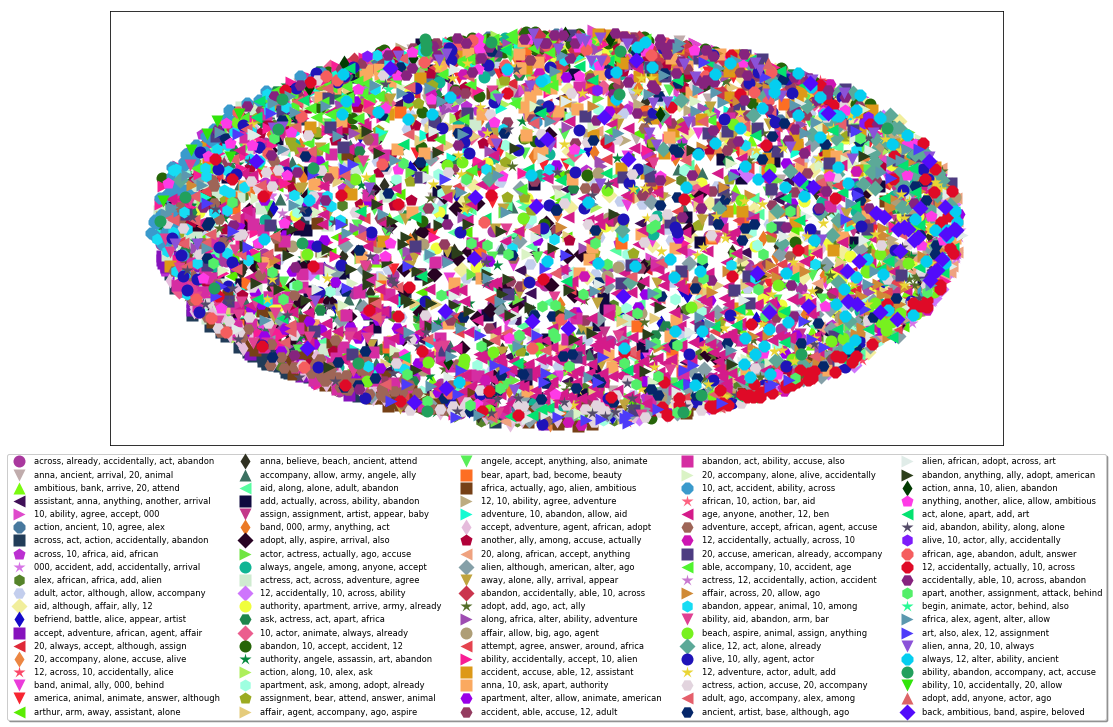

In [66]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=reduced_data,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 